In [1]:
# 2D Lattice Boltzmann python code
#@file double_shear_layer_bgk.py
#@author Emmanuel Leveque (emmanuel.leveque@gmail.com)
#@copyright Copyright (C) 2020 Emmanuel Leveque 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, draw, pause
import time

%matplotlib notebook

In [2]:
# parameters of the simulation

NX = 256
NY = NX

iter_max = 5000

k = 2*np.pi/float(NX)
M = 0.3
U0 = M/np.sqrt(3)
rho0 = 1. # reference density 
Re = 5000.
nu = U0*NX/Re
tau = 3*nu + 0.5

# D2Q9
npop = 9
w = np.asarray([4./9., 1./9., 1./9., 1./9., 1./9., 1./36., 1./36., 1./36., 1./36.])
ex = np.asarray([0, 1, 0, -1, 0, 1, -1, -1, 1])
ey = np.asarray([0, 0, 1, 0, -1, 1, 1, -1, -1])
lopp = np.asarray([0, 3, 4,  1,  2, 7,  8,  5,  6])

#--- definition ---
def equilibrium(rho, ux, uy):
    u2 = ux**2 + uy**2
    u_dot_e = np.tensordot(ex, ux, axes=0) + np.tensordot(ey, uy, axes=0) #tensor product
    feq = np.empty((npop, NX, NY))
    for l in range(npop):
        # second-order
        # see skordos 10.1103/PhysRevE.4 8.4 823
        feq[l, :, :] = w[l]*(rho-rho0 )+ w[l]*rho*(- 1.5*u2 + 3.*u_dot_e[l, :, :] + 4.5*u_dot_e[l, :, :]*u_dot_e[l, :, :])
        # third-order
        # feq[l, :, :] += -w[l]*rho*4.5*u_dot_e[l, :, :]*u2
        # fourth-order
        # feq[l, :, :] +=  w[l]*rho*(4.5*4.5*ux*ux*uy*uy*(ex[l]*ex[l]-1./3.)*(ey[l]*ey[l]-1./3.))
    return feq

def compute_macro(f_in):
    rho = rho0+np.sum(f_in, axis=0)
    ux = np.tensordot(ex, f_in, axes=1) / rho #tensor dot product
    uy = np.tensordot(ey, f_in, axes=1) / rho
    return rho, ux, uy


def collide(f_out, f_in, rho, ux, uy, tau):
    omega = 1./tau
    f_out[:, :, :] = (1. - omega) * f_in[:, :, :] + omega * equilibrium(rho, ux, uy)

    
def stream(f_out, f_in):
    for l in range(npop):
        f_out[l,:,:] = np.roll(np.roll(f_in[l, :, :],ex[l],axis=0),ey[l],axis=1)

In [3]:
#---init
f = np.zeros((npop, NX, NX))
fcoll = np.zeros((npop, NX, NY))
fold = np.zeros((npop, NX, NY))

rho = np.zeros((NX, NY))
ux = np.zeros((NX, NY))
uy = np.zeros((NX, NY))

#init 
for i in range(NX):
        for j in range(NY):
                #double shear layer
                if j <= NX/2:
                    ux[i, j] = U0*np.tanh(80*(j/NX-0.25))
                else:
                    ux[i, j] = U0*np.tanh(80*(0.75-j/NX))
                uy[i, j] = 0.05*U0*np.sin(2*np.pi*(i/float(NX)+0.25))
                rho[i, j] = 1.

fcoll = np.copy(equilibrium(rho, ux, uy))
fstream = np.copy(fcoll)
                
print("init total  mass "+str(np.sum(fcoll)+np.sum(rho0*np.ones((NX,NY)))))

init total  mass 65536.0


<IPython.core.display.Javascript object>


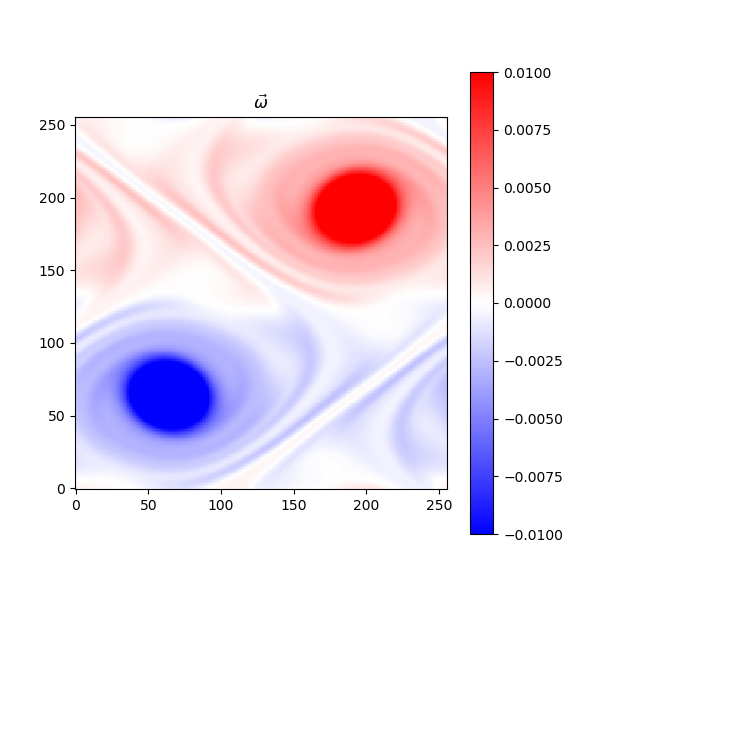

LBM starts...


In [ ]:
# -----LBM-BGK-----

fig_sim = figure(figsize=(6., 6.))
ax_sim = fig_sim .gca()
vorti = (np.gradient(uy, axis=0) - np.gradient(ux, axis=1)).T

im_sim = ax_sim.imshow(vorti, origin='lower', vmin=-0.01, vmax=+0.01, cmap='bwr')
ax_sim.set_title(r'$\vec{\omega}$')
fig_sim.colorbar(im_sim,ax=ax_sim)
plt.draw()
plt.show()        
fig_sim.canvas.draw()


print("LBM starts...")
start = time.time()
for t in range(1, iter_max+1):
    collide(fcoll, fstream, rho, ux ,uy, tau)
    stream(fstream, fcoll)
    rho, ux, uy = compute_macro(fstream)
    
    if t%100==0:
        vorti = (np.gradient(uy, axis=0) - np.gradient(ux, axis=1)).T
        im_sim.set_data(vorti)
        plt.draw()
        fig_sim.canvas.draw()


finish = time.time()

print("iteration: "+str(t)+" ... total  mass "+str(np.sum(fstream)+np.sum(rho0*np.ones((NX,NY))))+" in "+str(finish-start)+" s")
print("execution speed  =  "+str(NX*NY*t/(finish-start)/10**6)+" MLUPS in "+str(finish-start)+" s")